## Assess the impact of atmosphere on offset time-seris

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
figsize = [12,4]

from mintpy.objects import timeseries
from mintpy.utils import readfile, writefile, ptime, plot as pp, utils as ut
from mintpy import view

from unwrap_error import tec

work_dir = '/Users/yunjunz/data/ChileSenAT149/mintpyOffset'
os.chdir(work_dir)
print('Go to directory', work_dir)

tec_dir = os.path.expanduser('~/data/atmosphere/TEC')

# basic info - geometry and mask
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')
mask_file = os.path.join(work_dir, 'maskTempCoh.h5')
mask, atr = readfile.read(mask_file)
length, width = float(atr['LENGTH']), float(atr['WIDTH'])
num_pixel = length * width
center_idx = int(width * (length / 2) + width / 2)

Go to directory /Users/yunjunz/data/ChileSenAT149/mintpyOffset


### 1. Azimuth offset

open timeseries file: timeseriesAz.h5
save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_azOff.png


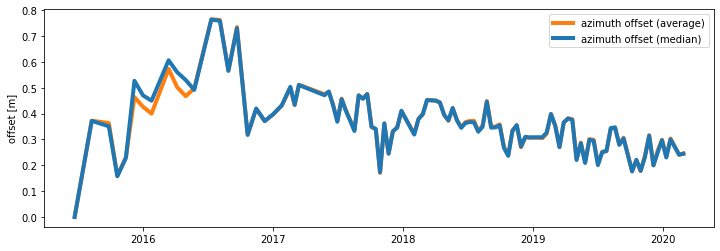

In [2]:
ts_file = 'timeseriesAz.h5'
ts_obj = timeseries(ts_file)
ts_obj.open()

## read data
ts_data = readfile.read(ts_file)[0]
ts_data = ts_data.reshape(ts_obj.numDate, -1)    # flatten
ts_data -= ts_data[0,:]                          # reference to the first date
ts_data[:, mask.flatten()==0] = np.nan           # mask invalid pixels

## calculate median and mean
ts_az_med = np.nanmedian(ts_data, axis=-1)
ts_az_avg = np.nanmean(ts_data, axis=-1)

## plot
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(ts_obj.times, ts_az_avg, linewidth=4, color=pp.mplColors[1], label='azimuth offset (average)')
ax.plot(ts_obj.times, ts_az_med, linewidth=4, color=pp.mplColors[0], label='azimuth offset (median)')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_azOff.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 2. Range offset

open timeseries file: timeseriesRg.h5
save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_rgOff.png


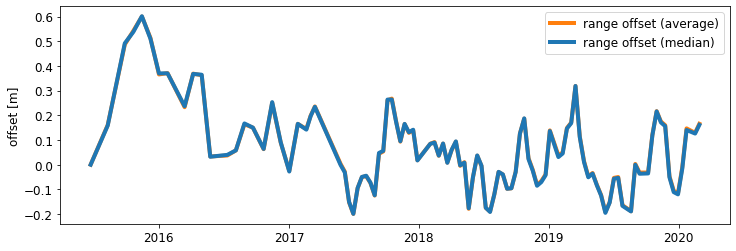

In [3]:
ts_file = 'timeseriesRg.h5'
ts_obj = timeseries(ts_file)
ts_obj.open()

## read data
ts_data = readfile.read(ts_file)[0]
ts_data = ts_data.reshape(ts_obj.numDate, -1)    # flatten
ts_data -= ts_data[0,:]                          # reference to the first date
ts_data[:, mask.flatten()==0] = np.nan           # mask invalid pixels

## calculate median and mean
ts_rg_med = np.nanmedian(ts_data, axis=-1)
ts_rg_avg = np.nanmean(ts_data, axis=-1)

## plot
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(ts_obj.times, ts_rg_avg, linewidth=4, color=pp.mplColors[1], label='range offset (average)')
ax.plot(ts_obj.times, ts_rg_med, linewidth=4, color=pp.mplColors[0], label='range offset (median)')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_rgOff.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3. Ionospheric delay

LOS vector lat/lon in ionosphere: -18.2 / -69.1 deg
LOS vector incidence angle in ionosphere: 35.7 deg
effective ionosphere height: 450000.0 m
save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_iono.png


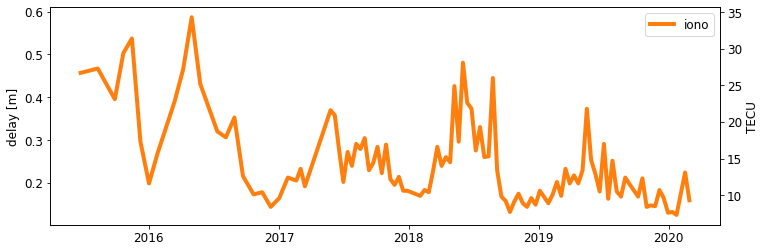

In [4]:
# 1.calculate ionospheric delay from IGS GNSS TEC
iono_file = os.path.join(work_dir, 'inputs/IgsTecJpl.h5')
if not os.path.isfile(iono_file):
    ts_obj = timeseries(ts_file)
    ts_obj.open()
    atr = ts_obj.metadata

    # download and calculation
    print('calculating the ionospheric delay from IGS GNSS TEC products...')
    ts_iono_delay = np.zeros((ts_obj.numDate, ts_obj.length, ts_obj.width), dtype=np.float32)
    ts_tecv = np.zeros(ts_obj.numDate, dtype=np.float32)
    prog_bar = ptime.progressBar(maxValue=ts_obj.numDate)
    for i in range(ts_obj.numDate):
        date_str = ts_obj.dateList[i]
        (rg_delay, 
         tecv,
         iono_lat,
         iono_lon, 
         iono_height,
         iono_inc_angle) = tec.get_iono_range_delay(tec_dir, date_str, geom_file, print_msg=False)
        ts_iono_delay[i,:,:] = rg_delay
        ts_tecv[i] = tecv
        prog_bar.update(i+1, suffix=date_str)
    prog_bar.close()

    # write to file
    atr['UNIT'] = 'm'
    atr['IONO_LAT'] = iono_lat
    atr['IONO_LON'] = iono_lon
    atr['IONO_HEIGHT'] = iono_height
    atr['IONO_INCIDENCE_ANGLE'] = np.nanmean(iono_inc_angle)
    dsDict = {}
    dsDict['timeseries'] = ts_iono_delay
    dsDict['zenithTEC'] = ts_tecv
    writefile.write(dsDict, out_file=iono_file, metadata=atr, ref_file=ts_file)

# 2. read data
atr = readfile.read_attribute(iono_file)
print('LOS vector lat/lon in ionosphere: {:.1f} / {:.1f} deg'.format(float(atr['IONO_LAT']), float(atr['IONO_LON'])))
print('LOS vector incidence angle in ionosphere: {:.1f} deg'.format(float(atr['IONO_INCIDENCE_ANGLE'])))
print('effective ionosphere height: {} m'.format(float(atr['IONO_HEIGHT'])))
with h5py.File(iono_file, 'r') as f:
    ts_data = f['timeseries'][:].reshape(ts_obj.numDate, -1)
    ts_tecv = f['zenithTEC'][:]

# 3. plot median / mean / center
# calculate median and mean
ts_iono_avg = np.nanmean(ts_data, axis=-1)
ts_iono_cen = ts_data[:, center_idx]
ts_iono_med = np.nanmedian(ts_data, axis=-1)

# plot
fig, ax = plt.subplots(figsize=figsize)
# ax 1 - delay
ax.plot(ts_obj.times, ts_iono_med, linewidth=4, color=pp.mplColors[1], label='iono')
ax.set_ylabel('delay [m]')
plt.legend()
# ax 1 - TEC
ax2 = ax.twinx()
ax2.plot(ts_obj.times, ts_tecv,    linewidth=4, color=pp.mplColors[0], alpha=0)
ax2.set_ylabel('TECU')
#ax.set_xlim(left=ts_obj.times[-30])

# output
out_fig = os.path.abspath('TS_iono.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 4. Tropospheric delay

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo.png


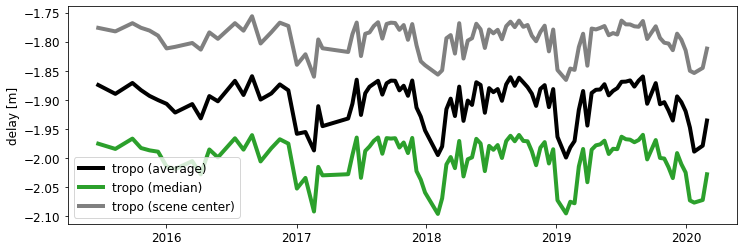

In [5]:
tropo_file = os.path.join(work_dir, 'inputs/ERA5.h5')

# 1. calculate absolute tropospheric delay from ERA5
if not os.path.isfile(tropo_file):
    !tropo_pyaps3.py -f timeseriesRg.h5 -g inputs/geometryRadar.h5

# 2. read data
ts_data = readfile.read(tropo_file)[0].reshape(ts_obj.numDate, -1)

# 3. plot median / mean / center
# calculate median and mean
ts_tropo_avg = np.nanmean(ts_data, axis=-1)
ts_tropo_med = np.nanmedian(ts_data, axis=-1)
ts_tropo_cen = ts_data[:, center_idx]

# plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_tropo_avg, linewidth=4, color='k',             label='tropo (average)')
ax.plot(ts_obj.times, ts_tropo_med, linewidth=4, color=pp.mplColors[2], label='tropo (median)')
ax.plot(ts_obj.times, ts_tropo_cen, linewidth=4, color='gray',          label='tropo (scene center)')
ax.set_ylabel('delay [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_tropo.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

#### Zoom-in the difference between median-average and median-center

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo_diff.png


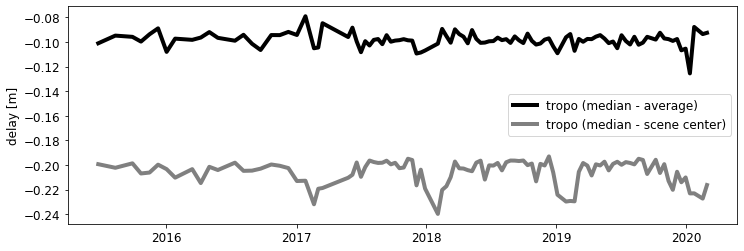

In [6]:
# plot median / mean / center difference
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_tropo_med - ts_tropo_avg, linewidth=4, color='k', label='tropo (median - average)')
ax.plot(ts_obj.times, ts_tropo_med - ts_tropo_cen, linewidth=4, color='gray', label='tropo (median - scene center)')
ax.set_ylabel('delay [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_tropo_diff.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

#### Variation between dry and wet troposphere

Dry troposphere: large absolute value with little variation

Wet troposphere: small absolute value with large  variation

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo_dry_wet.png


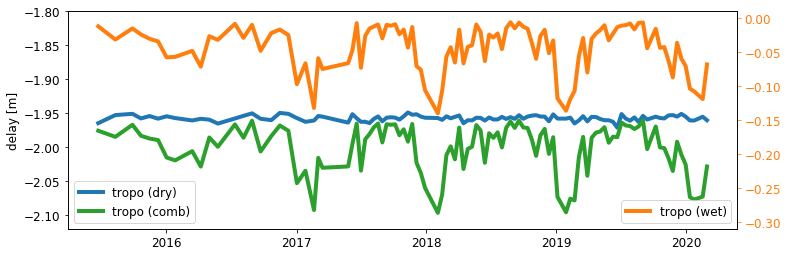

In [7]:
# 2. read data and calculate median
ts_dry  = np.nanmedian(readfile.read(os.path.join(work_dir, 'inputs/ERA5dry.h5'))[0].reshape(ts_obj.numDate, -1), axis=-1)
ts_wet  = np.nanmedian(readfile.read(os.path.join(work_dir, 'inputs/ERA5wet.h5'))[0].reshape(ts_obj.numDate, -1), axis=-1)
ts_comb = np.nanmedian(readfile.read(os.path.join(work_dir, 'inputs/ERA5.h5'))[0].reshape(ts_obj.numDate, -1), axis=-1)

# plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_dry,  linewidth=4, color=pp.mplColors[0], label='tropo (dry)')
ax.plot(ts_obj.times, ts_comb, linewidth=4, color=pp.mplColors[2], label='tropo (comb)')
ax.set_ylabel('delay [m]')
ax.set_ylim(-2.12, -1.8)   #0.32
ax.legend(loc='lower left')

ax2 = ax.twinx()
ax2.plot(ts_obj.times, ts_wet,  linewidth=4, color=pp.mplColors[1], label='tropo (wet)')
ax2.tick_params(which='both', axis='y', colors=pp.mplColors[1])
ax2.set_ylim(-0.31, 0.01)  #0.32
ax2.legend(loc='lower right')

# output
out_fig = os.path.abspath('TS_tropo_dry_wet.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 5. Compare range offset with ionospheric and tropospheric delay

In [8]:
# calculate the relative range delay
ts_iono = -1 * (ts_iono_med - ts_iono_med[0])
ts_tropo = ts_tropo_med - ts_tropo_med[0]
ts_atmos = ts_iono + ts_tropo

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_rgOff_iono_tropo.png


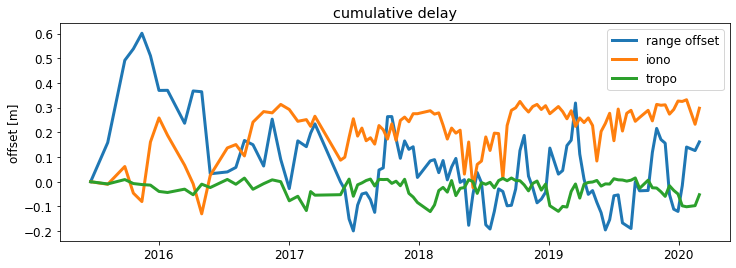

In [9]:
## plot
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_rg_med, linewidth=3, label='range offset')
ax.plot(ts_obj.times, ts_iono,   linewidth=3, label='iono')
ax.plot(ts_obj.times, ts_tropo,  linewidth=3, label='tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
ax.set_title('cumulative delay')
plt.legend()

# output
out_fig = os.path.abspath('TS_rgOff_iono_tropo.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/seqTS_rgOff_iono_tropo.png


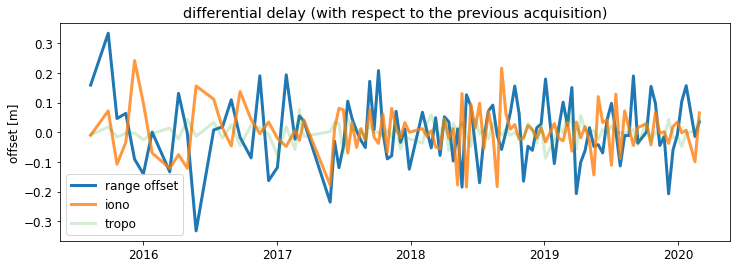

In [10]:
## plot
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times[1:], np.diff(ts_rg_med), linewidth=3, alpha=1, label='range offset')
ax.plot(ts_obj.times[1:], np.diff(ts_iono),   linewidth=3, alpha=0.8, label='iono')
ax.plot(ts_obj.times[1:], np.diff(ts_tropo),  linewidth=3, alpha=0.2, label='tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
ax.set_title('differential delay (with respect to the previous acquisition)')
plt.legend()

# output
out_fig = os.path.abspath('seqTS_rgOff_iono_tropo.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_rgOff_atmos.png


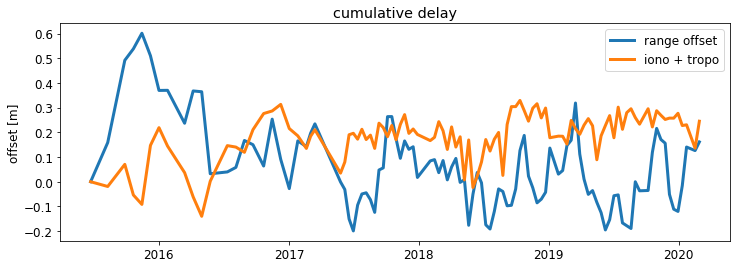

In [11]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times, ts_rg_med, linewidth=3, label='range offset')
ax.plot(ts_obj.times, ts_atmos,  linewidth=3, label='iono + tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
ax.set_title('cumulative delay')
plt.legend()

# output
out_fig = os.path.abspath('TS_rgOff_atmos.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/seqTS_rgOff_atmos.png


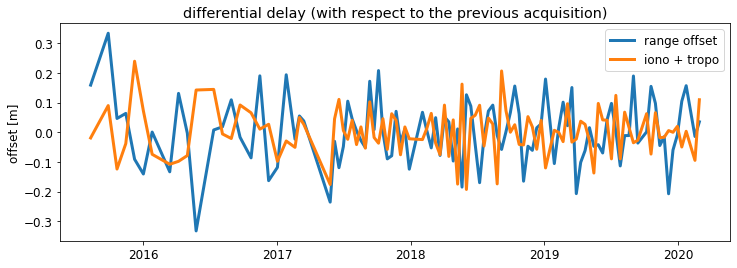

In [12]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(ts_obj.times[1:], np.diff(ts_rg_med), linewidth=3, label='range offset')
ax.plot(ts_obj.times[1:], np.diff(ts_atmos),  linewidth=3, label='iono + tropo')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
ax.set_title('differential delay (with respect to the previous acquisition)')
plt.legend()

# output
out_fig = os.path.abspath('seqTS_rgOff_atmos.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()